In [1]:
import os,shutil,sys, time
import numpy as np
import subprocess, shlex
import json

import collections

import argparse
import xml.etree.cElementTree as ET


import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tablib

In [2]:
def clean_values(x,y, cutend=-1):
    """
    Avoid doubles x-values by ensuring a monotonic increase in x, and ignoring the corresponding y.
    Loop from back to front, if x-value is not lower than previous value, ignore it.
    Working from back to front ensures correct (latest) values are used.
    Return clean x and y without doubles.
    """
    # cut end:
    if cutend != -1:
        new_x=[]
        new_y=[]
        for i,v in enumerate(x):
            if v<cutend:
                new_x.append(x[i])
                new_y.append(y[i])
    else:
        new_x=x
        new_y=y
    clean_y=[]
    clean_x=[]
    x=list(reversed(new_x))
    y=list(reversed(new_y))
    previous_x=999999999
    for i,v in enumerate(x):
        if v<previous_x:
            clean_x.append(v)
            clean_y.append(y[i])
            previous_x=v
        # else:
        #     print("ignore {}".format(v))
    return list(reversed(clean_x)), list(reversed(clean_y))

In [92]:
def save_append(dic, k, v):
    """Append a value to dictionary (dic)
    if it gives a key error, create a new list.
    """
    try:
        v=float(v)
    except: 
        pass
    try:
        dic[k].append(v)
    except KeyError:
        dic[k]=[v]

In [93]:
parser = argparse.ArgumentParser(description='Get results, combine them and save them in a pdf send to me.')
parser.add_argument('--home', default='/esat/opal/kkelchte/docker_home', type=str, help='Define the root directory: default is /esat/opal/kkelchte/docker_home/tensorflow/log')
parser.add_argument('--summary_dir', default='tensorflow/log/', type=str, help='Define the root directory: default is /esat/opal/kkelchte/docker_home/tensorflow/log')
parser.add_argument('--mother_dir', default='', type=str, help='if all runs are grouped in one mother directory in log: e.g. depth_q_net')
parser.add_argument('--blog_destination', default='', type=str, help='if image should be copied to blog imgs, specify the name.')
parser.add_argument('--log_folders', default=[],nargs='+', help="Define sub folders in motherdir to parse.")
parser.add_argument('--legend_names', default=[],nargs='+', help="Define the folder legends.")
parser.add_argument('--tags', default=[],nargs='+', help="Select certain tag within log file that needs to be combined.")
parser.add_argument('--subsample', default=1, type=int, help='To avoid cluttered images, subsample data making graph more smooth.')
parser.add_argument('--cutend', default=-1, type=int, help='Cut list of data earlier to cut the convergence tail.')

FLAGS, others = parser.parse_known_args()

In [148]:
# SETTINGS
FLAGS.subsample=5
# FLAGS.cutend=10000
FLAGS.tags=['train_accuracy','validation_accuracy']
# FLAGS.mother_dir='tiny_LSTM_1ss'
FLAGS.mother_dir='tiny_LSTM_net'
FLAGS.legend_names=['F-BPTT', 'WW-BPTT', 'S-BPTT'] 
# FLAGS.legend_names=['1K','5K','10K','20K','50K','100K','200K'] 

In [149]:
# Parse arguments and prepare variables:
if len(FLAGS.mother_dir) == len(FLAGS.log_folders) == 0:
    print("Missing log folder instructions. Please specify mother_dir / startswith / endswith argument.")
    
print("\nSettings:")
for f in FLAGS.__dict__: print("{0}: {1}".format( f, FLAGS.__dict__[f]))
print("Others: {0}".format(others))

log_root = FLAGS.home+'/'+FLAGS.summary_dir
log_folders=[log_root+f for f in FLAGS.log_folders]

if len(FLAGS.log_folders)==0:
    log_folders=[]
    for root, dirs, files in os.walk(log_root+FLAGS.mother_dir):
        dirs[:]=[d for d in dirs if not d[0]=='.']
        if ('tf_log' in os.listdir(root) or ('nn_ready' in os.listdir(root) and 'fsm_log' in os.listdir(root))):
            log_folders.append(root)
    log_folders=sorted(log_folders)
# log_folders=sorted([d[0] for d in os.walk(log_root+FLAGS.mother_dir) if not os.path.basename(d[0]).startswith('.') and ('tf_log' in os.listdir(d[0]) or ('nn_ready' in os.listdir(d[0]) and 'fsm_log' in os.listdir(d[0])))])

elif sum([os.path.isfile(f+'/tf_log') for f in log_folders]) != len(log_folders):
    log_folders=[d[0] for folder in FLAGS.log_folders for d in os.walk(log_root+folder) if 'tf_log' in os.listdir(d[0]) or ('nn_ready' in os.listdir(d[0]) and 'fsm_log' in os.listdir(d[0]))]

if len(log_folders)==0:
    print("Woops, could not find anything "+log_root+FLAGS.mother_dir+" and has an nn_ready log.")
else:
    print("Parsing "+str(len(log_folders))+" log_folders.")

colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']


Settings:
blog_destination: 
mother_dir: tiny_LSTM_net
tags: ['train_accuracy', 'validation_accuracy']
legend_names: ['F-BPTT', 'WW-BPTT', 'S-BPTT']
subsample: 5
cutend: 30000
summary_dir: tensorflow/log/
home: /esat/opal/kkelchte/docker_home
log_folders: []
Others: ['-f', '/run/user/5837/jupyter/kernel-2f2fe3d5-2f91-40fa-9d42-1ace23615857.json']
Parsing 6 log_folders.


In [150]:
results = {}

for folder_index, folder in enumerate(sorted(log_folders)):
    print("\n {0}/{1}: {2} \n".format(folder_index+1, len(log_folders),folder))
    results[folder] = {}
    # Parse online log_files: nn_ready and nn_log
    for file in ['nn_ready','nn_log','tf_log']:
        try:
            log_file=open(folder+'/'+file,'r').readlines()
        except:
            continue
        for line in log_file:
            if len(line.split(',')) > 2:
                for term in line.split(','):
                    try:
                        if len(term.split(":")) == 2:
                            save_append(results[folder], term.split(':')[0].strip(), term.split(':')[1].strip())
                            if file=='nn_ready':
                                run_keys.append(term.split(':')[0].strip())
                    except:
                        print("[{0}] failed to parse {1} term: {2}".format(os.path.basename(folder), log_file, term))

    print("Overview parsed information: ")
    for k in sorted(results[folder].keys()):
        print("{0}: {1} values".format(k, len(results[folder][k]) if len(results[folder][k]) != 1 else results[folder][k]))



 1/6: /esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/fbptt/01/seed_0 

Overview parsed information: 
final test run: 2 values
run: 33654 values
test_accuracy: 2 values
test_imitation_learning: 2 values
train_accuracy: 33654 values
train_imitation_learning: 33654 values
train_total: 33654 values
validation_accuracy: 33654 values
validation_imitation_learning: 33654 values

 2/6: /esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/fbptt/1/seed_0 

Overview parsed information: 
final test run: 2 values
run: 33595 values
test_accuracy: 2 values
test_imitation_learning: 2 values
train_accuracy: 33595 values
train_imitation_learning: 33595 values
train_total: 33595 values
validation_accuracy: 33595 values
validation_imitation_learning: 33595 values

 3/6: /esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/sbptt/01/seed_0 

Overview parsed information: 
final test run: 2 values
run: 133 values
test_accuracy: 2 values
test_imitation_learning: 2 values
train_ac

In [151]:
# For TINY:
# folders=['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_net/esatv3_expert_'+k+'/1/seed_0' for k in FLAGS.legend_names]

# For Alex:
# folders=['/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_1K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_5K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_10K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_20K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_50K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_100K/1/seed_0', 
#          '/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_200K/ref/1/seed_0']

# For LSTM graph

folders=['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/fbptt/1/seed_0', 
        '/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/wwbptt2/1/seed_0', 
        '/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/sbptt/1/seed_0']
# folders=['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/fbptt/1/seed_0', 
#         '/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/wwbptt/1/seed_0', 
#         '/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/sbptt/1/seed_0']

# folders=['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/wwbptt/01/seed_0']

for f in folders:
    if f not in results.keys():
        print 'help'

In [132]:
# len(results['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/sbptt/01/seed_0']['validation_accuracy'])
results['/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_1ss/wwbptt/01/seed_0']['run'][-1]


19600.0

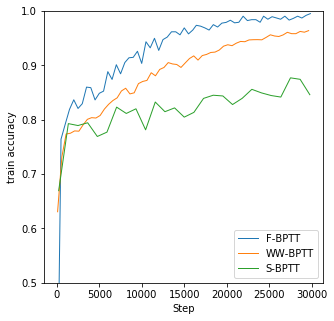

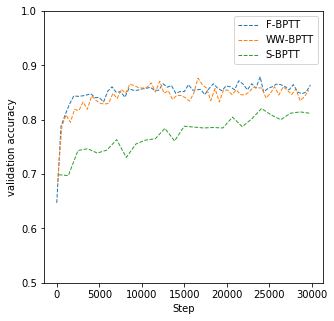

In [154]:
# TINY LSTM subsample high resolution of FBPTT
FLAGS.cutend=30000
plt.clf()
plt.cla()
plt.close()
legend=[]
labels=[]
all_fail=True
for tag in FLAGS.tags:
    fig=plt.figure(figsize=(5,5))
    for folder_index,l in enumerate(folders): #loop over log_folders    
        try:
            if len(FLAGS.legend_names) == len(folders):
                label=FLAGS.legend_names[folder_index]
            else:
                label=os.path.basename(l)
#             label+=' train' if 'train' in tag else ' validation'
            color=colors[folder_index%len(colors)]
            format_string={'validation_accuracy':'dashed',
                            'train_accuracy':'solid'}
            if 'run' in results[l].keys():
                if 'fbptt' in l:
                    # presubsample to come on even ground
                    x=list(results[l]['run'])[::100]
                    y=list(results[l][tag])[::100]
                else:
                    x=list(results[l]['run'])
                    y=list(results[l][tag])
                x,y=clean_values(x,y, cutend=FLAGS.cutend)
                plt.plot(x[::FLAGS.subsample],y[::FLAGS.subsample],
                         color=color,
                         linewidth=1, 
                         linestyle=format_string[tag],
                        label=label)
            else:
                plt.plot(range(len(results[l][tag][:FLAGS.cutend]))[::FLAGS.subsample],
                         results[l][tag][:FLAGS.cutend][::FLAGS.subsample],
                         color=color,
                         linewidth=1,
                         linystyle=format_string[tag],
                        label=label)
            
            legend.append(current_plot)
            labels.append(label)
            if len(results[l][tag][:FLAGS.cutend]) > 2 and type(results[l][tag][0]) == float: 
                all_fail=False # in case all models have only 2 values or no float values don't show
        except Exception as e:
            print e
            pass

    plt.xlabel("Step")
    plt.ylabel(tag.replace('_',' '))
    if 'accuracy' in tag and np.amin(results[l][tag][:FLAGS.cutend]) > 0.5:
    #         plt.ylabel('Accuracy')
        plt.ylim((0.5,1))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.legend()
    plt.savefig('/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_LSTM_net/overview_{0}.jpg'.format(tag),bbox_inches='tight')
    #     plt.show()

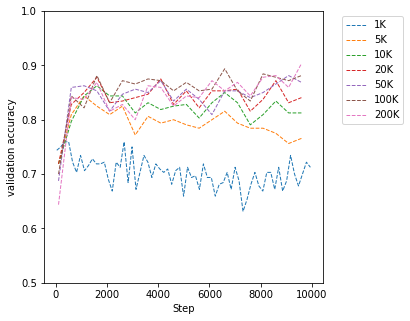

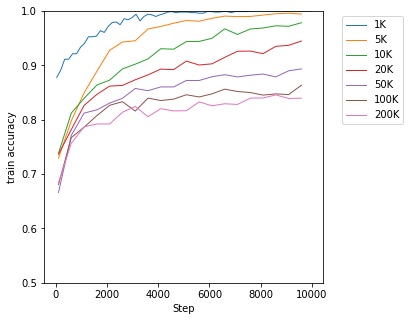

In [89]:
import matplotlib.lines as mlines
# ALEX and TINY print separate validation and train graph
plt.clf()
plt.cla()
plt.close()
legend=[]
labels=[]
all_fail=True
for tag in FLAGS.tags:
    fig=plt.figure(figsize=(5,5))

    for folder_index,l in enumerate(folders): #loop over log_folders
        try:
            if len(FLAGS.legend_names) == len(folders):
                label=FLAGS.legend_names[folder_index]
            else:
                label=os.path.basename(l)
#             label+=' train' if 'train' in tag else ' validate'
            color=colors[folder_index%len(colors)]
            format_string={'validation_accuracy':'dashed',
                            'train_accuracy':'solid'}
            if 'run' in results[l].keys():
                x,y=clean_values(list(results[l]['run']),list(results[l][tag]), cutend=FLAGS.cutend)
                plt.plot(x[::FLAGS.subsample],y[::FLAGS.subsample],
                         color=color,
                         linewidth=1, 
                         linestyle=format_string[tag],
                        label=label)
            else:
                plt.plot(range(len(results[l][tag][:FLAGS.cutend]))[::FLAGS.subsample],
                         results[l][tag][:FLAGS.cutend][::FLAGS.subsample],
                         color=color,
                         linewidth=1,
                         linystyle=format_string[tag],
                        label=label)
            
#             if len(legend)<len(folders): 
            legend.append(current_plot)
            labels.append(label)
#                 legend.append(mpatches.Patch(color=color, label=label.replace('_', ' ')))
            if len(results[l][tag][:FLAGS.cutend]) > 2 and type(results[l][tag][0]) == float: 
                all_fail=False # in case all models have only 2 values or no float values don't show
        except Exception as e:
            print e
            pass

    plt.xlabel("Step")
    plt.ylabel(tag.replace('_',' '))
    if 'accuracy' in tag and np.amin(results[l][tag][:FLAGS.cutend]) > 0.5:
#         plt.ylabel('Accuracy')
        plt.ylim((0.5,1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

    # plt.legend(handles=legend, labels=labels)
    # line_types = [mlines.Line2D([], [], color='black', marker='-', markersize=15, label='Train'),
    #               mlines.Line2D([], [], color='black', marker='.', markersize=15, label='Validate')]
    # plt.legend(handles=[line_types])
    # plt.gca().add_artist(line_types)    

#     plt.show()
    plt.savefig('/esat/opal/kkelchte/docker_home/tensorflow/log/tiny_net/overview_{0}.jpg'.format(tag),bbox_inches='tight')

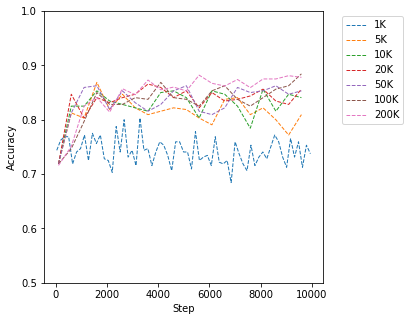

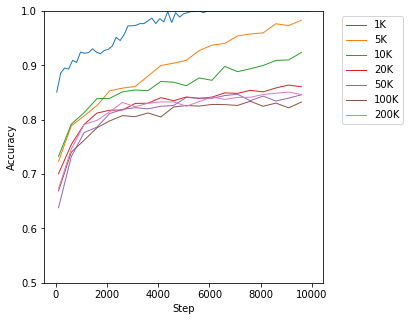

In [81]:
import matplotlib.lines as mlines
# ALEX and TINY print combined graph
plt.clf()
plt.cla()
plt.close()
fig=plt.figure(figsize=(5,5))
legend=[]
labels=[]
all_fail=True
for tag in FLAGS.tags:
    for folder_index,l in enumerate(folders): #loop over log_folders
        try:
            if len(FLAGS.legend_names) == len(folders):
                label=FLAGS.legend_names[folder_index]
            else:
                label=os.path.basename(l)
            label+=' train' if 'train' in tag else ' validate'
            color=colors[folder_index%len(colors)]
            format_string={'validation_accuracy':'dashed',
                            'train_accuracy':'solid'}
            if 'run' in results[l].keys():
                x,y=clean_values(list(results[l]['run']),list(results[l][tag]), cutend=FLAGS.cutend)
                plt.plot(x[::FLAGS.subsample],y[::FLAGS.subsample],
                         color=color,
                         linewidth=1, 
                         linestyle=format_string[tag],
                        label=label)
            else:
                plt.plot(range(len(results[l][tag][:FLAGS.cutend]))[::FLAGS.subsample],
                         results[l][tag][:FLAGS.cutend][::FLAGS.subsample],
                         color=color,
                         linewidth=1,
                         linystyle=format_string[tag],
                        label=label)
            
#             if len(legend)<len(folders): 
            legend.append(current_plot)
            labels.append(label)
#                 legend.append(mpatches.Patch(color=color, label=label.replace('_', ' ')))
            if len(results[l][tag][:FLAGS.cutend]) > 2 and type(results[l][tag][0]) == float: 
                all_fail=False # in case all models have only 2 values or no float values don't show
        except Exception as e:
            print e
            pass

plt.xlabel("Step")
plt.ylabel(tag.replace('_',' '))
if 'accuracy' in tag and np.amin(results[l][tag][:FLAGS.cutend]) > 0.5:
    plt.ylabel('Accuracy')
    plt.ylim((0.5,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
# plt.legend(handles=legend, labels=labels)
print len(legend)
print len(labels)
# line_types = [mlines.Line2D([], [], color='black', marker='-', markersize=15, label='Train'),
#               mlines.Line2D([], [], color='black', marker='.', markersize=15, label='Validate')]
# plt.legend(handles=[line_types])
# plt.gca().add_artist(line_types)    

# plt.show()
plt.savefig('/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/overview.jpg',bbox_inches='tight')